# Code brut du projet de simulation de figures d'interférences

## 1- Implémentation de deux fonctions permettant l'afichage des couleurs et la création de la colormap pour la figure d'interférence

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

def wavelength_to_rgb(wavelength, gamma=0.8):
    ''' taken from http://www.noah.org/wiki/Wavelength_to_RGB_in_Python
    This converts a given wavelength of light to an 
    approximate RGB color value. The wavelength must be given
    in nanometers in the range from 380 nm through 750 nm
    (789 THz through 400 THz).

    Based on code by Dan Bruton
    http://www.physics.sfasu.edu/astro/color/spectra.html
    Additionally alpha value set to 0.5 outside range
    '''
    wavelength = float(wavelength)
    if wavelength >= 380 and wavelength <= 750:
        A = 1.
    else:
        A=0.5
    if wavelength < 380:
        wavelength = 380.
    if wavelength >750:
        wavelength = 750.
    if wavelength >= 380 and wavelength <= 440:
        attenuation = 0.3 + 0.7 * (wavelength - 380) / (440 - 380)
        R = ((-(wavelength - 440) / (440 - 380)) * attenuation) ** gamma
        G = 0.0
        B = (1.0 * attenuation) ** gamma
    elif wavelength >= 440 and wavelength <= 490:
        R = 0.0
        G = ((wavelength - 440) / (490 - 440)) ** gamma
        B = 1.0
    elif wavelength >= 490 and wavelength <= 510:
        R = 0.0
        G = 1.0
        B = (-(wavelength - 510) / (510 - 490)) ** gamma
    elif wavelength >= 510 and wavelength <= 580:
        R = ((wavelength - 510) / (580 - 510)) ** gamma
        G = 1.0
        B = 0.0
    elif wavelength >= 580 and wavelength <= 645:
        R = 1.0
        G = (-(wavelength - 645) / (645 - 580)) ** gamma
        B = 0.0
    elif wavelength >= 645 and wavelength <= 750:
        attenuation = 0.3 + 0.7 * (750 - wavelength) / (750 - 645)
        R = (1.0 * attenuation) ** gamma
        G = 0.0
        B = 0.0
    else:
        R = 0.0
        G = 0.0
        B = 0.0
    return (R,G,B,A)

In [9]:
def make_color_map ( wavelength ):
    """ Return a LinearSegmentedColormap going from transparent to full intensity
    for a wavelength given in nanometer .
    wavelength : float (in nm)
    """
    R, G, B, A = wavelength_to_rgb ( wavelength )
    colors = [(R,G,B,c) for c in np. linspace (0 ,1 ,100)]
    return matplotlib.colors.LinearSegmentedColormap . from_list ("mycmap ", colors )

## 2- Définition de la classe et des fonctions nécessaires à la création et à l'affichage des -figures d'interférences  
(en monochromatique ou polychromatique)

In [111]:

#Fonction définissant le sinus cardinal
def sinc(x):
    return np.sinc(x/np.pi)

#Fonction renvoyant l'intensité en fonction des paramètres de l'expérience
def I(I0,d,a,X,lamb,f,N,theta):
    c=2*np.pi/((f*lamb))
    y=[]
    for x in X:
        if x!=0:
            y.append(I0*(np.sin(c*N*(x-f*np.sin(theta))*d/2)/(N*np.sin(c*(x-f*np.sin(theta))*d/2)))**2*(sinc(c*(x-f*np.sin(theta))*a/2))**2)
        else:
            y.append(I0)#Pour éviter une discontinuité en 0
    return y

#Définition de la classe interférence
class interference:
    
    def __init__(self,a,d,lamb,f,N,theta):
        self.a=a
        self.d=d
        self.lamb=lamb
        self.f=f
        self.N=N
        self.theta=theta
        I0=1
        self.I0=I0
        ordre=(2*self.lamb*self.f/self.a)
        self.ordre=ordre
        self.wv = self.lamb*10**9
        
    #Méthode créeant le graphe de l'intensité
    def graphe_intensite(self):
        X=np.linspace(-self.ordre,self.ordre,1000)
        In=I(self.I0,self.d,self.a,X,self.lamb,self.f,self.N,self.theta)
        return X,In
    
    #Méthode créeant la figure d'interférence
    def figure(self):
        X,I=self.graphe_intensite()
        y,x=np.meshgrid(I,X)
        comap=make_color_map(self.wv)
        extent=[-self.ordre,self.ordre,-self.ordre,self.ordre]
        return y, comap, extent
    
    #Méthode calculant l'ordre optimal pour plusieurs longueurs d'ondes
    def ordrepoly(self,lamb_tab):
        ordre=[]
        for l in lamb_tab:
            ordre.append(2*l*10**(-9)*self.f/self.a)
        ordrepoly=np.mean(ordre)
        self.ordre=ordrepoly
        
    #Méthode créeant la colorbar pour la figure
    def colorbar(self):
        R, G, B, A = wavelength_to_rgb (self.wv)
        colors = [(0, 0, 0), (R, G, B)]
        cm = LinearSegmentedColormap.from_list("Custom", colors, N=100)
        cmappable = ScalarMappable(norm=Normalize(0,1), cmap=cm)
        return cmappable

#Fonction affichant le graphe de l'intensité
def affichage_graphe(a,d,lamb,f,N,theta):
    alpha=0.5
    if len(lamb)==1:
        alpha=1    
    plt.figure()
    for l in lamb:
        inte=interference(a,d,l*10**(-9),f,N,theta)
        inte.ordrepoly(lamb)
        R, G, B, A = wavelength_to_rgb (inte.wv)
        X,Ig=inte.graphe_intensite()
        plt.xlabel("Position sur l'écran (m)")
        plt.ylabel("Intensité lumineuse (cd)")
        plt.plot(X,Ig,color=[R,G,B],alpha=alpha)
    plt.title("Graphique de l'intensité en fonction de la position sur l'écran")
    plt.show()
    
#Fonction affichant la figure d'intensité
def affichage_figure(a,d,lamb,f,N,theta):
    alpha=0.4
    if len(lamb)==1:
        alpha=1
    fig, ax = plt.subplots()
    for l in lamb:
        inte=interference(a,d,l*10**(-9),f,N,theta)
        inte.ordrepoly(lamb)
        R, G, B, A = wavelength_to_rgb (inte.wv)
        y,comap,extent=inte.figure()
        ax.imshow(y,cmap=comap, extent=extent,alpha=alpha)
        ax.yaxis.set_visible(False)
        plt.xlabel("Position sur l'écran (m)")
        if alpha==1:
            plt.colorbar(inte.colorbar())#Affichage de la colorbar grâce à la classe
    plt. gca (). set_facecolor ("0")
    plt.title("Figure d'interférence")
    plt. show()
    

# 3- Définition des paramètres par l'utilisateur et affichage du graphique et de la figure d'interférence

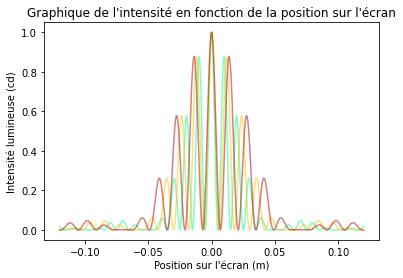

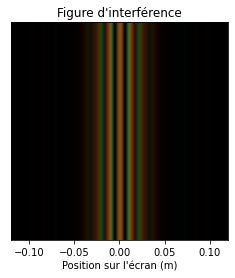

In [113]:
#Paramètres
d=50*10**(-6) #Distance entre les fentes
a=10*10**(-6) #Taille des fentes
f=1 #focale
N=2 #Nombres de fentes
theta=0 #Angle d'incidence de la source
lambda_=[500,600,700]#Tableau des longueurs d'onde en nm

#Affichage
affichage_graphe(a,d,lambda_,f,N,theta)
affichage_figure(a,d,lambda_,f,N,theta)